[reference of preprocess](https://www.pluralsight.com/guides/image-classification-with-pytorch)

In [3]:
!pip install --no-deps ../input/library-for-vision-transformer/timm-0.3.3-py3-none-any.whl

Processing /kaggle/input/library-for-vision-transformer/timm-0.3.3-py3-none-any.whl
timm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [4]:
import os
import pandas as pd
import timm
import albumentations as albu

In [5]:
path = "../input/cassava-leaf-disease-classification"
os.listdir(path)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [6]:
df = pd.read_csv(path + "/train.csv")

In [7]:
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [8]:
# dataframeの写真のIDをpathに変更する
df["path"] = df["image_id"].map(lambda x: path + "/train_images/" + x)
df = df.drop(columns=["image_id"])
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
from sklearn import model_selection

train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=42, stratify=df.label.values
)

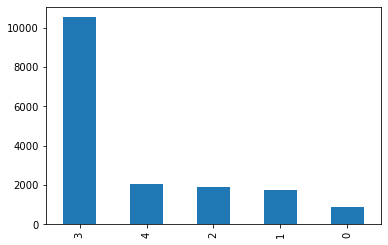

In [10]:
train_df.label.value_counts().plot(kind="bar")

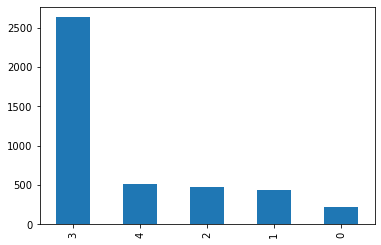

In [11]:
valid_df.label.value_counts().plot(kind="bar")

In [12]:
train_df = train_df.reset_index().drop(columns=["index"])
train_df.head()

,label,path
0,4,../input/cassava-leaf-disease-classification/t...
1,3,../input/cassava-leaf-disease-classification/t...
2,3,../input/cassava-leaf-disease-classification/t...
3,3,../input/cassava-leaf-disease-classification/t...
4,1,../input/cassava-leaf-disease-classification/t...


In [13]:
valid_df = valid_df.reset_index().drop(columns=["index"])
valid_df.head()

,label,path
0,3,../input/cassava-leaf-disease-classification/t...
1,3,../input/cassava-leaf-disease-classification/t...
2,3,../input/cassava-leaf-disease-classification/t...
3,3,../input/cassava-leaf-disease-classification/t...
4,3,../input/cassava-leaf-disease-classification/t...


In [14]:
from PIL import Image, ImageDraw

im = Image.open(train_df["path"][0])

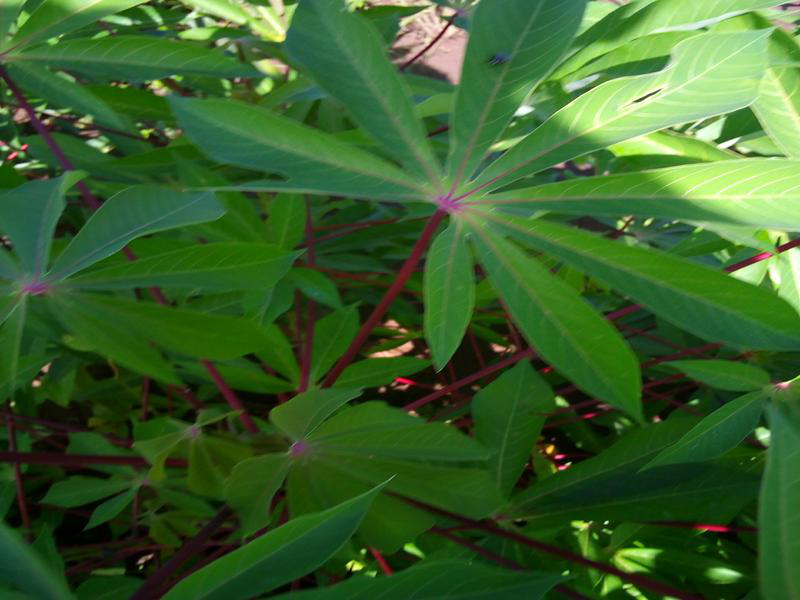

In [15]:
im

In [16]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset

from sklearn.model_selection import KFold

import matplotlib.image as img

# データ用の関数の定義

In [32]:
class CassavaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        super().__init__()
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df["path"])

    def __getitem__(self, index):
        # pathと正解ラベルの入手
        path = self.df["path"][index]
        label = self.df["label"][index]
        # 画像の読み込み
        with open(path, "rb") as f:
            image = Image.open(f)
            image = image.convert("RGB")
        # transformがあるときには、画像に適用する
        if self.transform is not None:
            image = self.transform(image)

        return image, label

TypeError: __init__() takes from 2 to 3 positional arguments but 4 were given

In [20]:
import random

In [21]:
class make_mask_image:
    def __init__(self, p, mask_size=50):
        self.p = p
        self.mask_size = mask_size

    def __call__(self, image):
        start_width, start_height = [], []
        if random.random() < self.p:
            draw = ImageDraw.Draw(image)
            width, height = image.size
            for i in range(10):
                start_width.append(random.randrange(0, width - self.mask_size))
                start_height.append(random.randrange(0, height - self.mask_size))
            for x, y in zip(start_width, start_height):
                draw.rectangle(
                    (x, y, x + self.mask_size, y + self.mask_size),
                    fill=(0, 0, 0),
                    outline=(0, 0, 0),
                )
        return image

In [22]:
# 学習データと評価データに対する画像の前処理の定義
image_size = 384
train_transform = transforms.Compose(
    [  # 大きさの変更
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(image_size),
        make_mask_image(p=0.3, mask_size=50),
        # tensor型に変更
        transforms.ToTensor(),
        # 正規化する
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [23]:
# datasetの作成
# train_data = CassavaDataset(train_df, train_transform)
# valid_data = CassavaDataset(valid_df, valid_transform)

In [40]:
dataset = CassavaDataset(df, train_transform)

In [41]:
# バッチ化
batch_size = 16
train_loader = DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0
)

valid_loader = DataLoader(
    dataset=valid_data, batch_size=batch_size, shuffle=False, num_workers=0
)

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [49]:
epoch = 5
batch_size = 16
num_classes = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
# モデルの作成
vit_model = timm.create_model("vit_base_patch32_384", pretrained=False)
vit_model.load_state_dict(
    torch.load(
        "../input/vit-base-models-pretrained-pytorch/jx_vit_base_p32_384-830016f5.pth"
    )
)
vit_model.head = nn.Linear(vit_model.head.in_features, num_classes)

vit_model = vit_model.to(device)

In [51]:
vit_optimizer = torch.optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=0.0001)
vit_scheduler = torch.optim.lr_scheduler.StepLR(vit_optimizer, step_size=2, gamma=0.1)

criterion=nn.CrossEntropyLoss()

In [52]:
def calc_correction(model, df):
    model.eval()
    path = df["path"]
    label = df["label"]
    count = 0
    pred_list = [0, 0, 0, 0, 0]
    for i in range(len(path)):
        image_path = path[i]
        image_label = label[i]
        image = Image.open(image_path)
        image = valid_transform(image)
        image = image.unsqueeze(0).to(device)
        model = model.to(device)
        pred = model(image).argmax(1).item()
        pred_list[pred] += 1
        if pred == image_label:
            count += 1
    percent = count / len(path)
    return percent, pred_list

In [53]:
# lossの表示をする
from matplotlib import pyplot as plt
def plot_losses(epoch, title, train_losses, valid_losses):
    y = list(range(epoch))
    train_loss = plt.plot(y, train_losses)
    valid_loss = plt.plot(y, valid_losses)
    plt.title(title)
    plt.ylabel("loss")
    plt.legend(
        (train_loss[0], valid_loss[0]), ("train loss", "valid loss"),
    )
    plt.show()


In [54]:
import time
def train_model(model, dataset, batch_size, optimizer, criterion, scheduler, epoch, model_title):
    best_model = None
    best_loss = float("inf")
    train_losses, valid_losses = [], []
    acc = []
    kf = KFold(n_splits = 3)
    for _fold, (train_index, valid_index) in enumerate(kf.split(dataset)):
        train_dataset = Subset(dataset, train_index)
        train_dataloader = DataLoader(train_dataset, batch_size, shuffle = True)
        valid_dataset = Subset(dataset, valid_index)
        valid_dataloader= DataLoader(valid_dataset, batch_size, shuffle = False)
        
        for epoch in range(1, epoch + 1):
            epoch_start_time = time.time()
            train_loss = 0
            valid_loss = 0

            model.train()
            for data, target in train_loader:
                data = data.to(device)
                target = target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*len(data)

            train_loss = train_loss/len(train_loader.sampler)
            train_losses.append(train_loss)

            model.eval()
            for data, target in valid_loader:
                data = data.to(device)
                target = target.to(device)

                with torch.no_grad():
                    output = model(data)
                    pred = (output.argmax(1) == target)
                    acc.append(sum(pred)/ len(pred))

                    loss = criterion(output, target)

                    valid_loss += loss.item()*len(data)
                    if valid_loss < best_loss:
                        best_model = model
                        best_loss = valid_loss
            scheduler.step()

            collection = sum(acc)/len(acc)
            valid_loss = valid_loss/len(valid_loader.sampler)
            valid_losses.append(valid_loss)
            print('Time: {:.3f}\t Epoch: {} \tTraining Loss: {:.3f} \tValidation Loss: {:.3f} \t Acc: {:.2f}'
                  .format(time.time() - epoch_start_time, epoch, train_loss, valid_loss, collection))
            num_collection = []
    torch.save(best_model.state_dict(), model_title)
    
    return best_model, train_losses, valid_losses

In [ ]:
model_title = "./vit_model.pth"
best_vit_model, train_losses, valid_losses = train_model(vit_model, 
                                                         dataset,
                                                         batch_size,
                                                         vit_optimizer,
                                                         criterion,
                                                         vit_scheduler, 
                                                         epoch,
                                                         model_title)
print(calc_correction(best_vit_model, valid_df))

In [ ]:
title = "vit losses"
plot_losses(epoch, title, train_losses, valid_losses)

In [ ]:
path = "../input/cassava-leaf-disease-classification/test_images/"

In [ ]:
image_path = []
image_id = []
for i in os.listdir(path):
    image_id.append(str(i))
    image_path.append(path + str(i))

In [ ]:
pred = []
for path in image_path:
    image = Image.open(path)
    image = valid_transform(image)
    image = image.unsqueeze(0).to(device)
    predict = vit_model(image).argmax(1).item()
    pred.append(predict)

In [ ]:
pred

In [ ]:
sub = pd.DataFrame({"image_id": image_id, "label": pred})

In [ ]:
sub

In [ ]:
sub.to_csv("submission.csv", index=False)